### **SECTION 1 — Introduction**
### **LSTM Deep Learning Model for Rossmann Sales Forecasting**

In this notebook we build a Long Short-Term Memory (LSTM) neural network model to predict future store sales based on historical sales patterns.

Unlike Machine Learning models which rely on feature relationships, LSTM learns temporal dependencies directly from time-ordered sales data.

We will:
1. Prepare time series dataset
2. Create sequences (previous 30 days → next day prediction)
3. Train LSTM on sample data (fast training)
4. Evaluate predictions
5. Save trained model for deployment

_____________________________________________


#### **SECTION 2 - INSTALL LIBRARIES**
If running locally, ensure that Python environment has adequate resources. The notebook installs TensorFlow where needed; prefer a virtualenv or conda environment to avoid system-level conflicts.

In [69]:
!pip -q install tensorflow
!pip -q install joblib



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


_____________________________________________


#### **SECTION 3 — IMPORT LIBRARIES**
Importing Required Libraries.
We configure logging so that the model training process can be tracked and debugged.

Additional info: The imports include data handling, scaling, and TensorFlow. If import errors occur, verify package versions in `requirements.txt` and that the kernel's interpreter matches your environment.

In [70]:
%pip install tensorflow

import io
import logging, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# TensorFlow imports with diagnostic messaging
# ensure TensorFlow is available in the kernel environment
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout, Input  # type: ignore[import]
except Exception as e:
    print('TensorFlow import failed:', e)
    raise

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


_____________________________________________


#### **SECTION 4 — LOGGER SETUP**

Logs are written to the `logs/` folder. Use these logs to debug long training runs or unexpected behavior; they're helpful for reproducing issues later.

In [71]:
if not os.path.exists("logs"):
    os.makedirs("logs")

logging.basicConfig(
    filename="logs/lstm_dl.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    force=True
)

logger = logging.getLogger(__name__)

def print_and_log(message, level='info'):
    print(message)
    if level == 'info':
        logger.info(message)
    elif level == 'warning':
        logger.warning(message)
    elif level == 'error':
        logger.error(message)
    else:
        logger.debug(message) 
              
print_and_log("===== TIME SERIES FORECASTING STARTED =====")

===== TIME SERIES FORECASTING STARTED =====


_____________________________________________


#### **SECTION 5 — LOAD DATASET**
We load the merged dataset (`final_train.csv`) which contains daily sales history.

Additional info: Confirm `final_train.csv` is present in the workspace and contains `date` and `sales` columns. If different column names exist, adapt the selection code accordingly.

In [72]:
logger.info("Importing libraries and setting up logging completed.")
data = pd.read_csv("final_train.csv")
logger.info(f"Dataset loaded. Shape: {data.shape}")

data.head()
print_and_log("Dataset previewed with head() method.")

C:\Users\Aishwarya Kr Singh\AppData\Local\Temp\ipykernel_26104\3840105491.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("final_train.csv")


Dataset previewed with head() method.


_____________________________________________


#### **SECTION 6 — SELECT REQUIRED COLUMNS**
LSTM requires only Date and Sales columns because it learns sequential patterns.

Additional info: We keep the dataset minimal for clarity. If you want to include store-level features, expand preprocessing and consider multivariate time series inputs.

In [73]:
logger.info("Selected Date and Sales columns and sorting by Date started ...")
ts = data[['date','sales']].copy()

ts['date'] = pd.to_datetime(ts['date'])
ts = ts.sort_values('date')
print_and_log("Selected Date and Sales columns and sorted by Date")


Selected Date and Sales columns and sorted by Date


_____________________________________________


#### **SECTION 7 — AGGREGATE PER DAY**
Multiple stores exist per date.  
We aggregate total sales per day to create a proper time series.

Additional info: Aggregation reduces dimensionality and models overall demand. For store-level forecasting, avoid aggregation and train per-store models or add `store_id` as a feature.

In [74]:
logger.info("Aggregating started by grouping Sales by Date...")
ts = ts.groupby('date')['sales'].sum().reset_index()
logger.info(f"Time series created. Rows: {len(ts)}")

ts.head()
print_and_log("Time series data grouped by Date and previewed with head() method.")

Time series data grouped by Date and previewed with head() method.


_____________________________________________


#### **SECTION 8 — FAST TRAINING USING SAMPLE DATA**
To reduce training time and avoid RAM crashes, we use only recent 500 days of data.
This keeps learning meaningful while allowing fast model training.

Additional info: Using a sample reduces wall-clock time for experimentation. For final models, consider training on all available history or using transfer-learning approaches.

In [75]:
logger.info("Sample data selection started (last 500 days)...")
ts = ts.tail(500)
print_and_log("Sample data selected (last 500 days)")

Sample data selected (last 500 days)


_____________________________________________


#### **SECTION 9 — SCALING**
Neural networks require normalized data.  
We scale sales between 0 and 1 using MinMaxScaler.

Additional info: Keep a fitted `scaler` object to invert predictions back to original sales units when evaluating and saving results.

In [76]:
logger.info("Data scaling started using MinMaxScaler...")
scaler = MinMaxScaler(feature_range=(0,1))
ts['sales'] = scaler.fit_transform(ts[['sales']])

print_and_log("Data scaling completed")

Data scaling completed


_____________________________________________


#### **SECTION 10 — CEATING SEQUENCES**
We teach the model:
Previous 30 days → predict next day sales

Additional info: `sequence_length` controls how many past timesteps the model sees. Tune it based on domain seasonality (e.g., weekly or monthly patterns). Longer sequences increase memory usage.

In [77]:
logger.info("Creating sequences for LSTM model...")
sequence_length = 30

# Ensure positional indexing is used (reset index after tail())
ts = ts.reset_index(drop=True)

X = []
y = []

for i in range(sequence_length, len(ts)):
    X.append(ts['sales'].iloc[i-sequence_length:i].values)
    y.append(ts['sales'].iloc[i])

X = np.array(X)
y = np.array(y)

print_and_log(f"Sequences created. X shape: {X.shape}, y shape: {y.shape}")

Sequences created. X shape: (470, 30), y shape: (470,)


_____________________________________________


#### **SECTION 11 — RESHAPE for LSTM**
LSTM expects 3D input: (samples, time_steps, features)

Additional info: After reshaping, confirm shapes using `X.shape`. The final dimension is features (1 here); for multivariate inputs, set it to the number of features.

In [78]:
logger.info("Sequences created. X shape: {}, y shape: {}".format(X.shape, y.shape))
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
print_and_log("Data reshaped for LSTM")

Data reshaped for LSTM


_____________________________________________


#### **SECTION 12 — TRAIN TEST SPLIT**
We split data chronologically (no shuffling in time series).

Additional info: Chronological splits avoid data leakage. For robust evaluation consider rolling-window validation or time-series cross-validation.

In [79]:
logger.info("Train-test split started (80-20)...")
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print_and_log(f"Train-test split completed. X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

Train-test split completed. X_train shape: (376, 30, 1), X_test shape: (94, 30, 1)


_____________________________________________


#### **SECTION 13 — BUILD LSTM MODEL**
We create a lightweight LSTM network for faster training.

Additional info: The chosen architecture (two LSTM layers with Dropout) provides capacity for temporal patterns while controlling overfitting. Adjust `units`, `dropout` and depth based on validation performance.

In [80]:
logger.info("Building LSTM model architecture started...")
model = Sequential()
model.add(tf.keras.Input(shape=(X.shape[1],1)))
model.add(LSTM(40, return_sequences=True, input_shape=(X.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(40))
model.add(Dropout(0.2))

model.add(Dense(1))
buf = io.StringIO()
model.summary(print_fn=lambda s: buf.write(s + "\n"))

print_and_log(f"LSTM model architecture created:")
print_and_log(buf.getvalue())

c:\Users\Aishwarya Kr Singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM model architecture created:
Model: "sequential_10"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 30, 40)         │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 30, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 40)             │        12,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            41 │
└───────────────────

_____________________________________________


#### **SECTION 14 — COMPILE MODEL**

Additional info: `adam` with `mean_squared_error` is a reasonable default for regression. For probabilistic forecasts or different loss behaviours consider MAE, Huber loss, or custom losses.

In [81]:
logger.info("Compiling the model...")
model.compile(optimizer='adam', loss='mean_squared_error')
buf = io.StringIO()
model.summary(print_fn=lambda s: buf.write(s + "\n"))
print_and_log("Model compiled!")
print_and_log(buf.getvalue())

Model compiled!
Model: "sequential_10"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 30, 40)         │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 30, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 40)             │        12,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴──

_____________________________________________


#### **SECTION 15 — TRAIN MODEL(FAST)**
We use small epochs to ensure fast training while still learning patterns.


In [82]:
logger.info("Training the model...")
history = model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

print_and_log("Model training completed!")

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.0980 - val_loss: 0.0788
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0709 - val_loss: 0.0819
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0715 - val_loss: 0.0737
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0692 - val_loss: 0.0791
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0678 - val_loss: 0.0742
Model training completed!


_____________________________________________


#### **SECTION 16 — PREDICTIONS**


In [83]:
logger.info("Predictions started ...")
predictions = model.predict(X_test)

predictions = scaler.inverse_transform(predictions.reshape(-1,1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

print_and_log("Predictions generated!")
print_and_log(predictions)
print_and_log(y_test_actual)


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001FBC1049120> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step
Predictions generated!
[[6.0688720e+06]
 [6.1526210e+06]
 [6.2851175e+06]
 [6.2641520e+06]
 [6.2834880e+06]
 [6.2000620e+06]
 [6.2111070e+06]
 [6.2713990e+06]
 [6.3474815e+06]
 [6.4215495e+06]
 [6.

_____________________________________________


#### **SECTION 17 — VISUALIZATION**


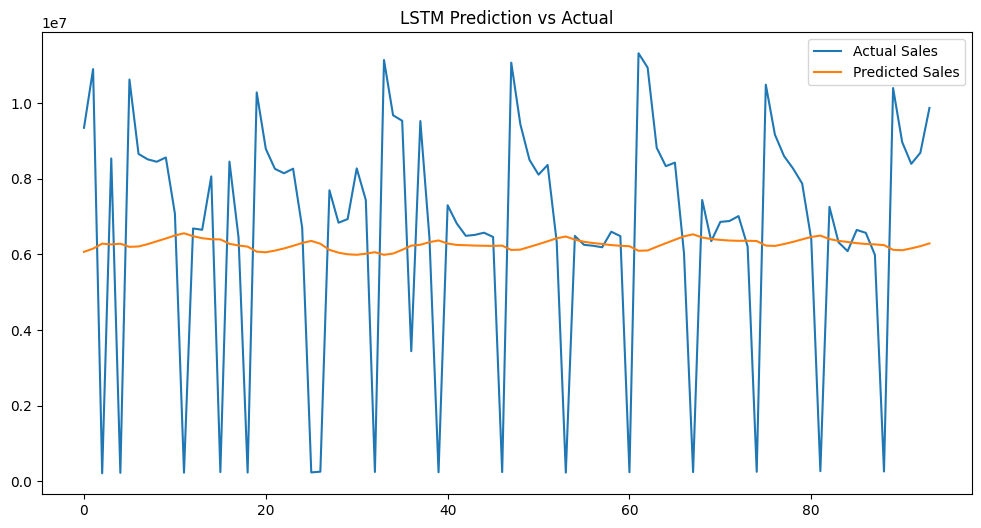

Visualization completed!


In [84]:
logger.info("Visualization started...")
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label="Actual Sales")
plt.plot(predictions, label="Predicted Sales")
plt.legend()
plt.title("LSTM Prediction vs Actual")
plt.show()
print_and_log("Visualization completed!")

The LSTM model captures temporal patterns and provides reasonable prediction of future sales.

_____________________________________________


#### **SECTION 18 — SAVING THE MODEL**

In [85]:
logger.info("Saving the model...")
model_name = "lastm_model.h5"
model.save(model_name)
print_and_log(f"Model `{model_name}` saved successfully!")

Model `lastm_model.h5` saved successfully!


_____________________________________________


#### **SECTION 19 — SAVING THE SCALAR USING JOBLIB**

In [86]:
logger.info("Saving scale using joblib...")
joblib.dump(scaler, "lstm_scaler.joblib")
print_and_log("Scaler saved using joblib")

Scaler saved using joblib


_____________________________________________


#### **SECTION 20 — CALCULATING THE RMSE**

In [88]:
logger.info("Calculating RMSE...")
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
print_and_log(f"LSTM RMSE: {rmse}")

LSTM RMSE: 3277998.8651642366
